# SI 671 Project

Members: Jingjie Wan (iriswan)

In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["figure.figsize"] = (20,10)

## 1. Load Data

In [2]:
data = pd.read_csv("Crash_Reporting_-_Drivers_Data.csv")

In [3]:
data.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,MCP3040003N,190026050,Montgomery County Police,Property Damage Crash,05/31/2019 03:00:00 PM,NaN,NaN,NaN,NaN,PARKING LOT OF 3215 SPARTAN RD,...,15,No,No,2004,HONDA,TK,UNKNOWN,39.150044,-77.063089,"(39.15004368, -77.06308884)"
1,MCP1307000K,190024786,Montgomery County Police,Property Damage Crash,05/24/2019 05:00:00 PM,NaN,NaN,NaN,NaN,PARKING LOT,...,0,No,No,0,UNK,UNK,NaN,39.199047,-77.250743,"(39.19904667, -77.25074333)"
2,MCP2846008X,230034260,Montgomery County Police,Property Damage Crash,07/17/2023 10:45:00 AM,County,SELFRIDGE RD,County,RANDOLPH RD,NaN,...,35,No,No,2003,FORD,TK,NO MISUSE,39.054588,-77.085974,"(39.05458848, -77.08597423)"
3,MCP32610017,230034668,Montgomery County Police,Property Damage Crash,07/20/2023 11:40:00 PM,Maryland (State),MUNCASTER MILL RD,County,SHADY GROVE RD,NaN,...,45,No,No,2023,TOYT,CP,NO MISUSE,39.148721,-77.147111,"(39.14872076, -77.14711061)"
4,EJ78520081,230033429,Gaithersburg Police Depar,Property Damage Crash,07/13/2023 05:40:00 PM,Municipality,PERRY PKWY,Unknown,ENT TO SHOPPING CENTER,NaN,...,25,No,No,2001,KENWORTH,TRUCK,NaN,39.149085,-77.210731,"(39.14908542, -77.21073135)"


In [4]:
data.shape

(167799, 43)

In [5]:
data.columns

Index(['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Type',
       'Cross-Street Name', 'Off-Road Description', 'Municipality',
       'Related Non-Motorist', 'Collision Type', 'Weather',
       'Surface Condition', 'Light', 'Traffic Control',
       'Driver Substance Abuse', 'Non-Motorist Substance Abuse', 'Person ID',
       'Driver At Fault', 'Injury Severity', 'Circumstance',
       'Driver Distracted By', 'Drivers License State', 'Vehicle ID',
       'Vehicle Damage Extent', 'Vehicle First Impact Location',
       'Vehicle Second Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Vehicle Continuing Dir', 'Vehicle Going Dir',
       'Speed Limit', 'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year',
       'Vehicle Make', 'Vehicle Model', 'Equipment Problems', 'Latitude',
       'Longitude', 'Location'],
      dtype='object')

## 2. Task 1: Identify key contributing factors to the injury severity in accidents.

### 2.1 Exploratory Data Analysis (EDA) 

### 2.1.0 Basic information

In [6]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167799 entries, 0 to 167798
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Report Number                   167799 non-null  object 
 1   Local Case Number               167799 non-null  object 
 2   Agency Name                     167799 non-null  object 
 3   ACRS Report Type                167799 non-null  object 
 4   Crash Date/Time                 167799 non-null  object 
 5   Route Type                      151248 non-null  object 
 6   Road Name                       152227 non-null  object 
 7   Cross-Street Type               151217 non-null  object 
 8   Cross-Street Name               152216 non-null  object 
 9   Off-Road Description            15570 non-null   object 
 10  Municipality                    18530 non-null   object 
 11  Related Non-Motorist            5317 non-null    object 
 12  Collision Type  

In [7]:
data.isnull().sum()

Report Number                          0
Local Case Number                      0
Agency Name                            0
ACRS Report Type                       0
Crash Date/Time                        0
Route Type                         16551
Road Name                          15572
Cross-Street Type                  16582
Cross-Street Name                  15583
Off-Road Description              152229
Municipality                      149269
Related Non-Motorist              162482
Collision Type                       571
Weather                            13037
Surface Condition                  19654
Light                               1393
Traffic Control                    24921
Driver Substance Abuse             30580
Non-Motorist Substance Abuse      163598
Person ID                              0
Driver At Fault                        0
Injury Severity                        0
Circumstance                      137249
Driver Distracted By                   0
Drivers License 

### 2.1.1 Data Preprocessing

In [8]:
# map injury severity to number
severity_mapping = {
    'NO APPARENT INJURY': 0, 'POSSIBLE INJURY': 1, 'SUSPECTED MINOR INJURY': 2, 'SUSPECTED SERIOUS INJURY': 3, 'FATAL INJURY': 4
}
data['severity_num'] = data['Injury Severity'].map(severity_mapping).astype(int)


In [9]:
# One-hot encoding - choose the features with fewer missing values
df = pd.get_dummies(data, columns=['Route Type'], prefix='route_type')
df = pd.get_dummies(df, columns=['Collision Type'], prefix='collision_type')
df = pd.get_dummies(df, columns=['Weather'], prefix='weather')
df = pd.get_dummies(df, columns=['Surface Condition'], prefix='surface')
df = pd.get_dummies(df, columns=['Light'], prefix='light')
df["Driver Substance"] = df['Driver Substance Abuse'].apply(lambda x:
                                    'substance_unknown' if pd.isna(x) == True or x == 'UNKNOWN'
                                    else 'substance_other' if x == 'OTHER'
                                    else 'no_substance' if x == 'NONE DETECTED'
                                    else 'yes_substance')
df = pd.get_dummies(df, columns=['Driver Substance'], prefix='driver_substance')
df = pd.get_dummies(df, columns=['Driver At Fault'], prefix='driver_at_fault')
df["Driver Distracted"] = df['Driver Distracted By'].apply(lambda x:
                                    'distracted_unknown' if pd.isna(x) == True or x == 'UNKNOWN'
                                    else 'distracted_no_driver' if x == 'NO DRIVER PRESENT'
                                    else 'no_distracted' if x == 'NOT DISTRACTED'
                                    else 'yes_distracted')
df = pd.get_dummies(df, columns=['Driver Distracted'], prefix='driver_distracted')
df = pd.get_dummies(df, columns=['Vehicle Body Type'], prefix='vehicle_body')
df = pd.get_dummies(df, columns=['Vehicle Movement'], prefix='vehicle_movement')
df = pd.get_dummies(df, columns=['Equipment Problems'], prefix='equipment_problems')
# map vehicle damage extent to number
df["vehicle_damage_num"] = df['Vehicle Damage Extent'].apply(lambda x:
                                    0 if x == 'NO DAMAGE'
                                    else 1 if x == 'SUPERFICIAL'
                                    else 2 if x == 'FUNCTIONAL'
                                    else 3 if x == 'DISABLING'
                                    else 4 if x == 'DESTORYED'
                                    else -1)
df

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,Municipality,...,equipment_problems_BELT(S) MISUSED,equipment_problems_BELTS/ANCHORS BROKE,equipment_problems_FACING WRONG WAY,equipment_problems_NO MISUSE,equipment_problems_NOT STREPPED RIGHT,equipment_problems_OTHER,equipment_problems_SIZE/TYPE IMPROPER,equipment_problems_STRAP/TETHER LOOSE,equipment_problems_UNKNOWN,vehicle_damage_num
0,MCP3040003N,190026050,Montgomery County Police,Property Damage Crash,05/31/2019 03:00:00 PM,NaN,NaN,NaN,PARKING LOT OF 3215 SPARTAN RD,NaN,...,0,0,0,0,0,0,0,0,1,1
1,MCP1307000K,190024786,Montgomery County Police,Property Damage Crash,05/24/2019 05:00:00 PM,NaN,NaN,NaN,PARKING LOT,NaN,...,0,0,0,0,0,0,0,0,0,2
2,MCP2846008X,230034260,Montgomery County Police,Property Damage Crash,07/17/2023 10:45:00 AM,SELFRIDGE RD,County,RANDOLPH RD,NaN,NaN,...,0,0,0,1,0,0,0,0,0,1
3,MCP32610017,230034668,Montgomery County Police,Property Damage Crash,07/20/2023 11:40:00 PM,MUNCASTER MILL RD,County,SHADY GROVE RD,NaN,NaN,...,0,0,0,1,0,0,0,0,0,1
4,EJ78520081,230033429,Gaithersburg Police Depar,Property Damage Crash,07/13/2023 05:40:00 PM,PERRY PKWY,Unknown,ENT TO SHOPPING CENTER,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167794,DM8338000C,16010228,Takoma Park Police Depart,Property Damage Crash,03/01/2016 10:01:00 AM,NEW HAMPSHIRE SERVICE LA,Municipality,PRINCE GEORGES AVE,NaN,TAKOMA PARK,...,0,0,0,1,0,0,0,0,0,1
167795,MCP1182001S,170519976,Montgomery County Police,Property Damage Crash,07/19/2017 02:22:00 PM,CEDAR LA,Maryland (State),OLD GEORGETOWN RD,NaN,NaN,...,0,0,0,1,0,0,0,0,0,3
167796,MCP1453008X,200046217,Montgomery County Police,Property Damage Crash,11/23/2020 07:37:00 AM,RIDGE RD,Unknown,LITTLE SENECA PKWY,NaN,NaN,...,0,0,0,1,0,0,0,0,0,2
167797,MCP2568000M,190056701,Montgomery County Police,Property Damage Crash,11/23/2019 11:23:00 PM,SHADY GROVE RD,Ramp,RAMP 9 FR IS 370 EB TO SHADY GROVE RD,NaN,NaN,...,0,0,0,1,0,0,0,0,0,2


In [10]:
# Get time elements for part 3
# Convert 'Crash Date/Time' to datetime
df['Crash Date/Time'] = pd.to_datetime(df['Crash Date/Time'])

# Create time-related features, e.g., hour, day of the week, month
df['Hour of Day'] = df['Crash Date/Time'].dt.hour
df['Day of Week'] = df['Crash Date/Time'].dt.dayofweek
df['Month'] = df['Crash Date/Time'].dt.month

# Group by these features and calculate the average injury severity
hourly_severity = df.groupby('Hour of Day')['severity_num'].mean()
weekly_severity = df.groupby('Day of Week')['severity_num'].mean()
monthly_severity = df.groupby('Month')['severity_num'].mean()

### 2.1.2 Correlation

vehicle_body_MOTORCYCLE                    0.156844
Speed Limit                                0.113450
collision_type_SAME DIRECTION SIDESWIPE    0.090954
driver_at_fault_No                         0.085308
driver_at_fault_Yes                        0.085119
vehicle_movement_MOVING CONSTANT SPEED     0.083906
collision_type_OTHER                       0.079704
equipment_problems_UNKNOWN                 0.076393
collision_type_HEAD ON LEFT TURN           0.076257
vehicle_movement_BACKING                   0.070988
collision_type_STRAIGHT MOVEMENT ANGLE     0.070108
collision_type_HEAD ON                     0.064495
driver_substance_substance_unknown         0.063300
Latitude                                   0.062033
vehicle_damage_num                         0.059254
vehicle_body_PASSENGER CAR                 0.058917
route_type_Maryland (State)                0.057525
driver_substance_no_substance              0.053291
vehicle_body_TRANSIT BUS                   0.052693
vehicle_body

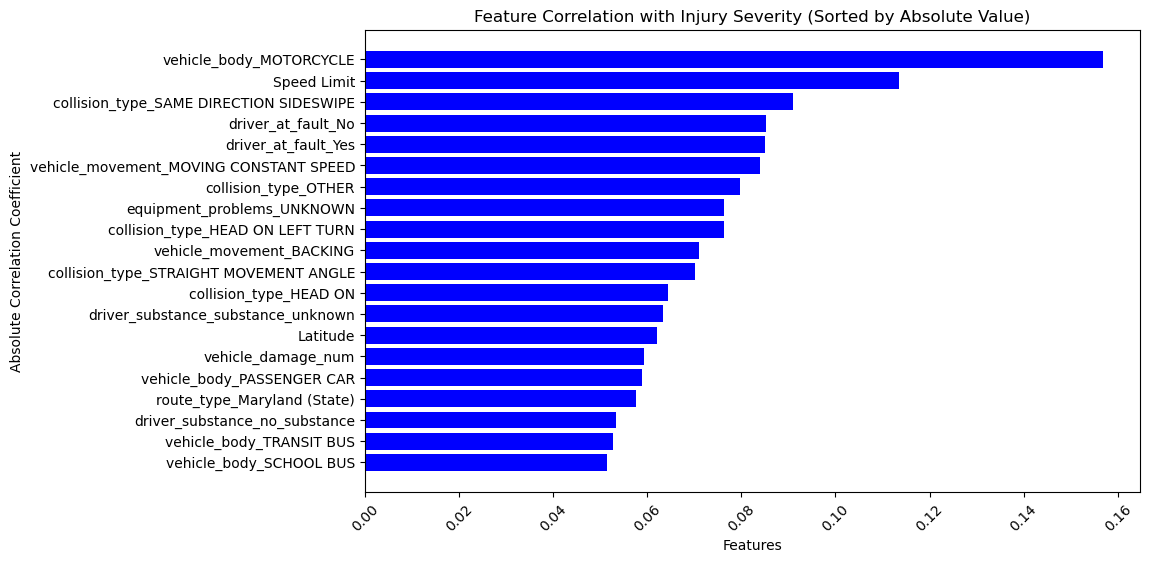

In [11]:
# Calculate correlation of 'severity_num' with other columns
correlation_with_severity = df.corr()['severity_num'].drop('severity_num').abs()

# Sort the correlations
sorted_correlation = correlation_with_severity.sort_values(ascending=False)[:20]

# Print the sorted correlations
print(sorted_correlation)

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the size as needed
sorted_correlation = sorted_correlation[::-1]
plt.barh(sorted_correlation.index, sorted_correlation.values, color='blue')  # You can change the color

# Adding title and labels
plt.title('Feature Correlation with Injury Severity (Sorted by Absolute Value)')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation Coefficient')
plt.xticks(rotation=45)  # Rotates the feature names for better visibility

# Show the plot
#plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

In [12]:
sorted_correlation.index

Index(['vehicle_body_SCHOOL BUS', 'vehicle_body_TRANSIT BUS',
       'driver_substance_no_substance', 'route_type_Maryland (State)',
       'vehicle_body_PASSENGER CAR', 'vehicle_damage_num', 'Latitude',
       'driver_substance_substance_unknown', 'collision_type_HEAD ON',
       'collision_type_STRAIGHT MOVEMENT ANGLE', 'vehicle_movement_BACKING',
       'collision_type_HEAD ON LEFT TURN', 'equipment_problems_UNKNOWN',
       'collision_type_OTHER', 'vehicle_movement_MOVING CONSTANT SPEED',
       'driver_at_fault_Yes', 'driver_at_fault_No',
       'collision_type_SAME DIRECTION SIDESWIPE', 'Speed Limit',
       'vehicle_body_MOTORCYCLE'],
      dtype='object')

In [13]:
df_select = df[['Injury Severity', 'severity_num', 'vehicle_body_MOTORCYCLE', 'Speed Limit',
       'collision_type_SAME DIRECTION SIDESWIPE', 'driver_at_fault_No',
       'driver_at_fault_Yes', 'vehicle_movement_MOVING CONSTANT SPEED',
       'collision_type_OTHER', 'equipment_problems_UNKNOWN',
       'collision_type_HEAD ON LEFT TURN', 'vehicle_movement_BACKING',
       'collision_type_STRAIGHT MOVEMENT ANGLE', 'collision_type_HEAD ON',
       'driver_substance_substance_unknown', 'Latitude', 'vehicle_damage_num',
       'vehicle_body_PASSENGER CAR', 'route_type_Maryland (State)',
       'driver_substance_no_substance', 'vehicle_body_TRANSIT BUS',
       'vehicle_body_SCHOOL BUS']]
df_select

,Injury Severity,severity_num,vehicle_body_MOTORCYCLE,Speed Limit,collision_type_SAME DIRECTION SIDESWIPE,driver_at_fault_No,driver_at_fault_Yes,vehicle_movement_MOVING CONSTANT SPEED,collision_type_OTHER,equipment_problems_UNKNOWN,...,collision_type_STRAIGHT MOVEMENT ANGLE,collision_type_HEAD ON,driver_substance_substance_unknown,Latitude,vehicle_damage_num,vehicle_body_PASSENGER CAR,route_type_Maryland (State),driver_substance_no_substance,vehicle_body_TRANSIT BUS,vehicle_body_SCHOOL BUS
0,NO APPARENT INJURY,0,0,15,0,0,1,0,1,1,...,0,0,1,39.150044,1,1,0,0,0,0
1,NO APPARENT INJURY,0,0,0,0,0,1,0,0,0,...,0,0,1,39.199047,2,1,0,0,0,0
2,NO APPARENT INJURY,0,0,35,0,0,1,1,1,0,...,0,0,1,39.054588,1,1,0,0,0,0
3,NO APPARENT INJURY,0,0,45,0,1,0,0,1,0,...,0,0,1,39.148721,1,1,1,0,0,0
4,NO APPARENT INJURY,0,0,25,0,0,1,1,0,0,...,0,0,1,39.149085,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167794,NO APPARENT INJURY,0,0,25,0,1,0,0,1,0,...,0,0,1,38.972560,1,0,0,0,0,0
167795,NO APPARENT INJURY,0,0,35,0,0,1,0,0,0,...,0,0,1,39.004640,3,1,0,0,0,0
167796,NO APPARENT INJURY,0,0,40,0,1,0,0,0,0,...,0,0,0,39.228963,2,0,1,1,0,0
167797,NO APPARENT INJURY,0,0,35,0,1,0,0,0,0,...,0,0,0,39.120440,2,0,0,1,0,0


vehicle_body_MOTORCYCLE                    0.156844
Speed Limit                                0.113450
driver_at_fault_No                         0.085308
vehicle_movement_MOVING CONSTANT SPEED     0.083906
collision_type_HEAD ON LEFT TURN           0.076257
collision_type_STRAIGHT MOVEMENT ANGLE     0.070108
collision_type_HEAD ON                     0.064495
Latitude                                   0.062033
vehicle_damage_num                         0.059254
vehicle_body_PASSENGER CAR                 0.058917
route_type_Maryland (State)                0.057525
driver_substance_no_substance              0.053291
vehicle_body_SCHOOL BUS                   -0.051445
vehicle_body_TRANSIT BUS                  -0.052693
driver_substance_substance_unknown        -0.063300
vehicle_movement_BACKING                  -0.070988
equipment_problems_UNKNOWN                -0.076393
collision_type_OTHER                      -0.079704
driver_at_fault_Yes                       -0.085119
collision_ty

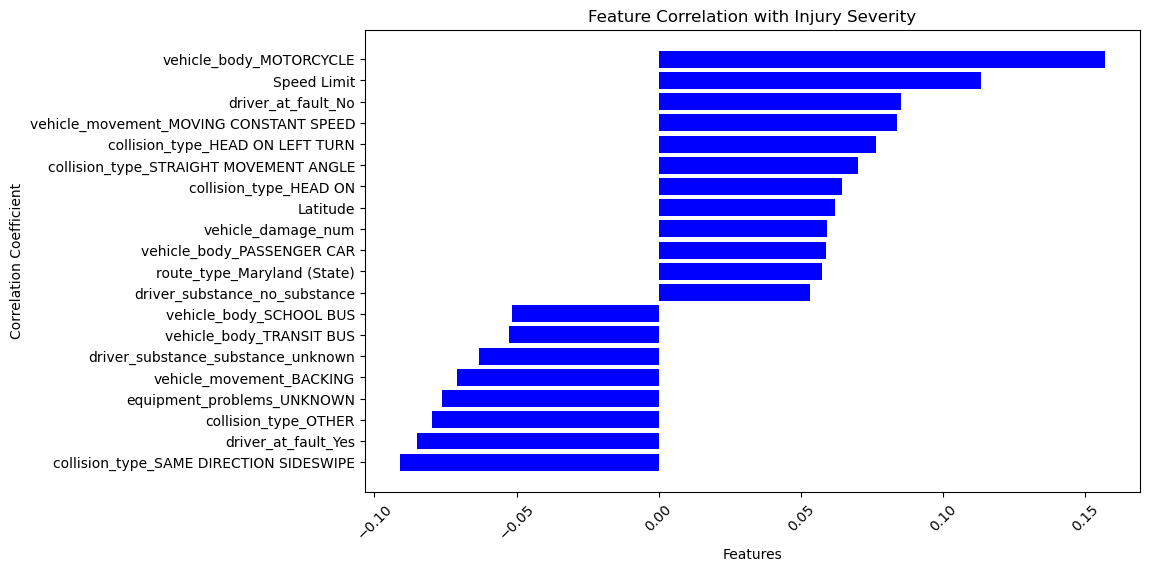

In [14]:
# Calculate correlation of 'severity_num' with other columns
correlation_with_severity = df_select.corr()['severity_num'].drop('severity_num')

# Sort the correlations
sorted_correlation = correlation_with_severity.sort_values(ascending=False)

# Print the sorted correlations
print(sorted_correlation)

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the size as needed
sorted_correlation = sorted_correlation[::-1]
plt.barh(sorted_correlation.index, sorted_correlation.values, color='blue')  # You can change the color

# Adding title and labels
plt.title('Feature Correlation with Injury Severity')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)  # Rotates the feature names for better visibility

# Show the plot
#plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

### 2.2.1 Predict with the features

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Data Preprocessing
# Convert categorical variables using one-hot encoding or label encoding
# Ensure all NaN values are handled appropriately

# Splitting the dataset into training and testing sets
X = df_select.drop(['Injury Severity', 'severity_num'], axis=1)  # Features
y = df_select[ 'severity_num']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features (if necessary)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model Training and Evaluation
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    #'SVM': SVC(probability=True),
    'xgb': xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.3, use_label_encoder=False, eval_metric='mlogloss'),
    'MLP': MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42),
    #'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

best_f1_score = 0
best_model = None

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions, average='weighted')  # Choose 'macro', 'micro', or 'weighted'
    print(f"{name} F1 Score: {f1}")
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model

Logistic Regression F1 Score: 0.7447443311844457
Random Forest F1 Score: 0.729364604850196
xgb F1 Score: 0.7465273446527434
MLP F1 Score: 0.7454658917989957
Naive Bayes F1 Score: 0.30546061935606056


### Best model: XGBoost Classifier

In [16]:
best_model

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, ...)

### 2.2.2 Get Feature Importance

vehicle_damage_num                         0.132729
equipment_problems_UNKNOWN                 0.100808
collision_type_SAME DIRECTION SIDESWIPE    0.099453
driver_substance_substance_unknown         0.096519
driver_at_fault_Yes                        0.094888
driver_at_fault_No                         0.091003
vehicle_body_MOTORCYCLE                    0.075332
vehicle_body_TRANSIT BUS                   0.060147
vehicle_body_SCHOOL BUS                    0.051713
collision_type_OTHER                       0.040959
vehicle_movement_BACKING                   0.027761
collision_type_HEAD ON                     0.022206
Speed Limit                                0.020027
vehicle_body_PASSENGER CAR                 0.017706
vehicle_movement_MOVING CONSTANT SPEED     0.016637
route_type_Maryland (State)                0.011847
collision_type_HEAD ON LEFT TURN           0.011441
driver_substance_no_substance              0.010540
collision_type_STRAIGHT MOVEMENT ANGLE     0.009408
Latitude    

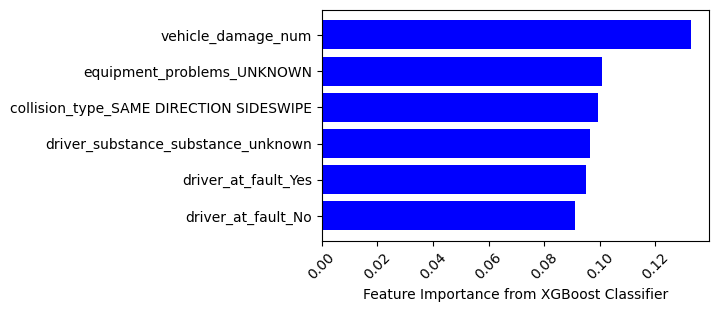

In [17]:
# Best model: XGBoost
# Feature Importance from the best model
# This step depends on the model chosen. For example, if Random Forest is the best:
importances = best_model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feature_importances)

# Create a bar plot
plt.figure(figsize=(5, 3))  # Adjust the size as needed
feature_importances = feature_importances[:6][::-1]
plt.barh(feature_importances.index, feature_importances.values, color='blue')  # You can change the color

# Adding title and labels
#plt.xlabel('Features')
plt.xlabel('Feature Importance from XGBoost Classifier')
plt.xticks(rotation=45)  # Rotates the feature names for better visibility

# Show the plot
#plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

## 3. Task 2: Time Series Analysis

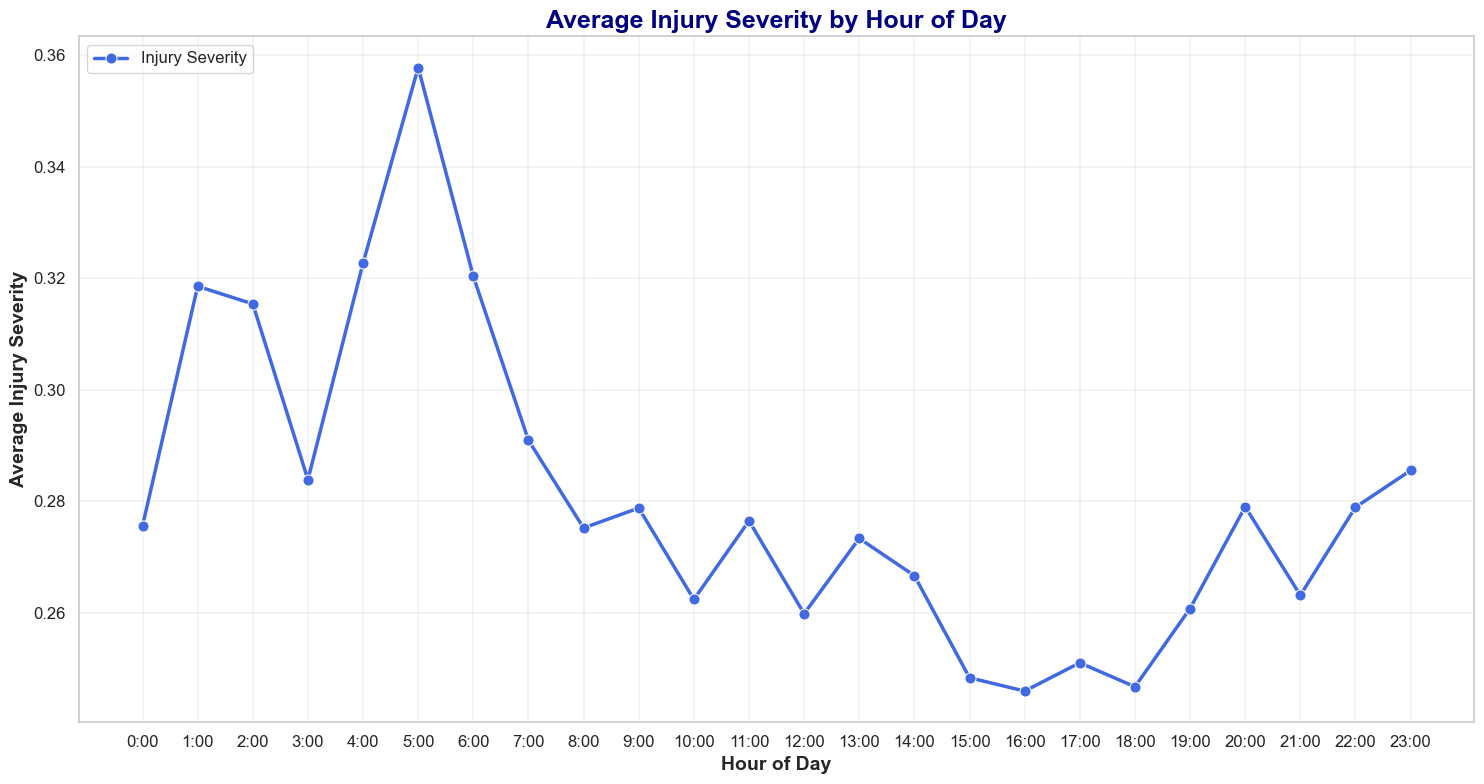

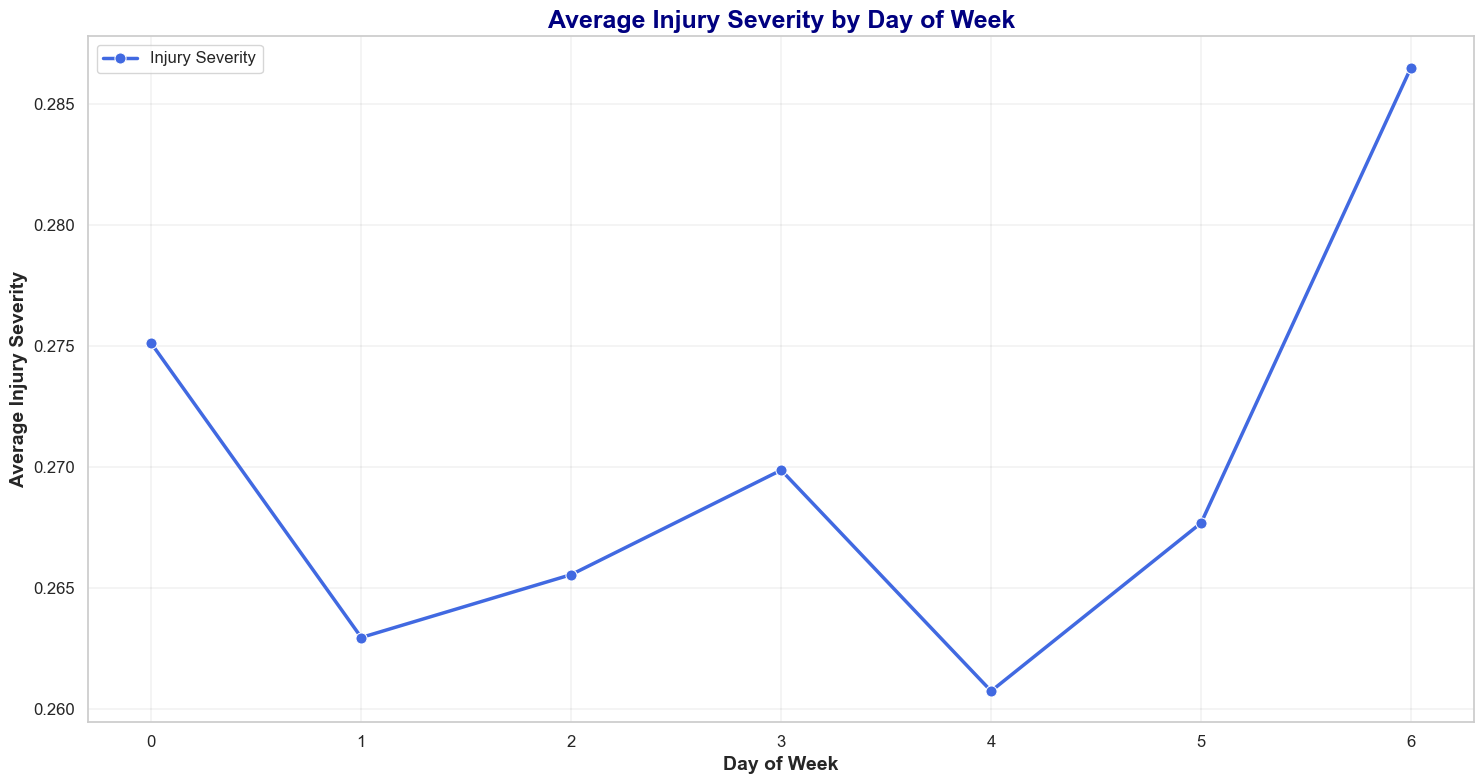

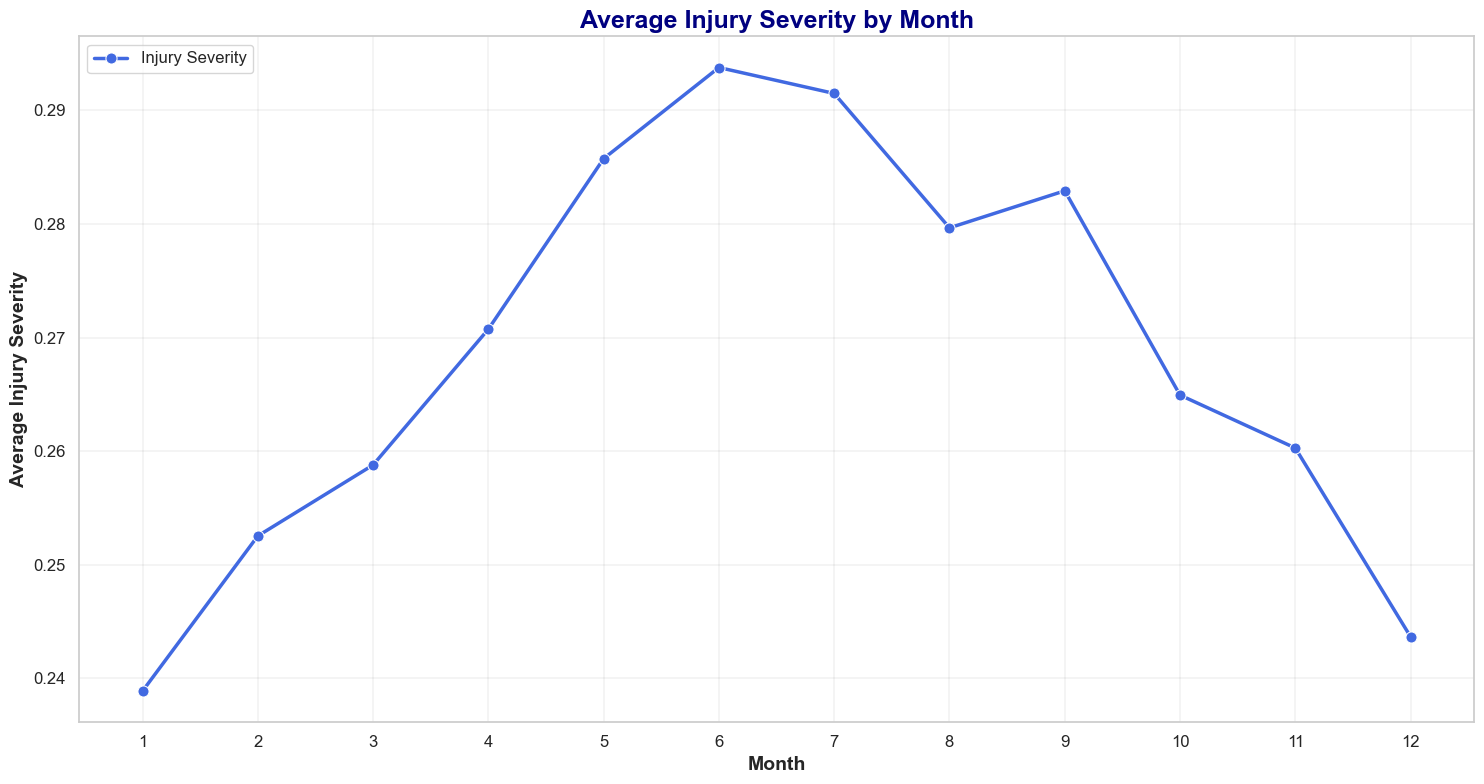

In [18]:
import matplotlib.ticker as mticker
# Plotting with Enhanced Aesthetics
plt.figure(figsize=(15, 8))

# Using Seaborn for better aesthetics
sns.set(style="whitegrid")

# Create a line plot
sns.lineplot(x=hourly_severity.index, y=hourly_severity.values, color='royalblue', marker='o', markersize=8, linewidth=2.5)

# Adding titles and labels
plt.title('Average Injury Severity by Hour of Day', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Hour of Day', fontsize=14, fontweight='bold')
plt.ylabel('Average Injury Severity', fontsize=14, fontweight='bold')

# Customizing tick parameters
plt.xticks(range(0, 24), fontsize=12)
plt.yticks(fontsize=12)
plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%d:00'))  # Format x-axis labels as 'Hour:00'

# Adding a grid for better readability
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Customizing the legend
plt.legend(['Injury Severity'], fontsize=12, frameon=True, loc='upper left')

# Optional: Adding annotations or customizing further based on specific insights from the data

# Show the plot
plt.tight_layout()
plt.show()






plt.figure(figsize=(15, 8))

# Using Seaborn for better aesthetics
sns.set(style="whitegrid")

# Create a line plot
sns.lineplot(x=weekly_severity.index, y=weekly_severity.values, color='royalblue', marker='o', markersize=8, linewidth=2.5)

# Adding titles and labels
plt.title('Average Injury Severity by Day of Week', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Day of Week', fontsize=14, fontweight='bold')
plt.ylabel('Average Injury Severity', fontsize=14, fontweight='bold')

# Customizing tick parameters
plt.xticks(range(0, 7), fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%d:00'))  # Format x-axis labels as 'Hour:00'

# Adding a grid for better readability
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Customizing the legend
plt.legend(['Injury Severity'], fontsize=12, frameon=True, loc='upper left')

# Optional: Adding annotations or customizing further based on specific insights from the data

# Show the plot
plt.tight_layout()
plt.show()





plt.figure(figsize=(15, 8))

# Using Seaborn for better aesthetics
sns.set(style="whitegrid")

# Create a line plot
sns.lineplot(x=monthly_severity.index, y=monthly_severity.values, color='royalblue', marker='o', markersize=8, linewidth=2.5)

# Adding titles and labels
plt.title('Average Injury Severity by Month', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Average Injury Severity', fontsize=14, fontweight='bold')

# Customizing tick parameters
plt.xticks(range(1, 13), fontsize=12)
plt.yticks(fontsize=12)
#plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%d:00'))  # Format x-axis labels as 'Hour:00'

# Adding a grid for better readability
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

# Customizing the legend
plt.legend(['Injury Severity'], fontsize=12, frameon=True, loc='upper left')

# Optional: Adding annotations or customizing further based on specific insights from the data

# Show the plot
plt.tight_layout()
plt.show()

In [28]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

In [29]:
time = df[['Crash Date/Time', 'severity_num']]
time.set_index('Crash Date/Time', inplace=True)
ts = time['severity_num'].resample('D').mean().fillna(method='bfill')  # Adjust resampling as needed

# Split the data
split_point = int(len(ts) * 0.8)
ts_train, ts_test = ts[0:split_point], ts[split_point:]

In [30]:
# fit ARIMA Model
arima_model = ARIMA(ts_train, order=(3, 0, 1))  # Adjust order as necessary
arima_model_fit = arima_model.fit()

In [31]:
X_train = np.arange(len(ts_train)).reshape(-1, 1)
y_train = ts_train.values

In [32]:
# ARIMA Predictions
arima_predictions = arima_model_fit.forecast(steps=len(ts_test))

In [33]:
arima_rmse = mean_squared_error(ts_test, arima_predictions)

In [34]:
import xgboost as xgb
time = df.copy()
time.set_index('Crash Date/Time', inplace=True)
ts = time['severity_num'].resample('D').mean().fillna(method='bfill')  # Adjust resampling as needed

def create_features(ts, lag=1):
    return pd.concat(
        [ts.shift(i) for i in range(lag, -1, -1)],
        axis=1
    )

lag = 3  # Number of lagged features
ts_lagged = create_features(ts, lag)
ts_lagged.columns = ['Lag_' + str(lag - i) for i in range(lag + 1)]
ts_lagged.dropna(inplace=True)

X = ts_lagged.drop('Lag_0', axis=1)
y = ts_lagged['Lag_0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
def random_search_tuning():
    final_X = X_train
    final_y = y_train

    params = {'max_depth': [3, 6, 9],
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
              'subsample': np.arange(0.5, 1.0, 0.1),
              'colsample_bytree': np.arange(0.3, 1.0, 0.1),
              'colsample_bylevel': np.arange(0.3, 1.0, 0.1),
              'n_estimators': [250, 500, 750, 900]
              }

    xgbclf = xgb.XGBRegressor(objective="reg:squarederror", random_state=0)
    clf = RandomizedSearchCV(estimator=xgbclf,
                             param_distributions=params,
                             n_iter=25,
                             n_jobs=4,
                             verbose=1)

    clf.fit(final_X, final_y)

    best_combination = clf.best_params_

    return best_combination

In [ ]:
random_search_tuning()

In [36]:
from sklearn.dummy import DummyRegressor
model = xgb.XGBRegressor(objective ='reg:squarederror', max_depth = 3, random_state=0, subsample=0.7, n_estimators=500, learning_rate=0.01, colsample_bylevel=0.4, colsample_bytree=0.7)
model.fit(X_train, y_train)

dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)

y_pred = model.predict(X_test)
dummy_predictions = dummy.predict(X_test)
xgb_rmse = mean_squared_error(y_test, y_pred)
dummy_rmse = mean_squared_error(ts_test, dummy_predictions)

print("Dummy Regression MSE:", dummy_rmse)
print("ARIMA MSE:", arima_rmse)
print("XGBoost Regression MSE: ", xgb_rmse)

Dummy Regression MSE: 0.011864413582964277
ARIMA MSE: 0.011556073106609126
XGBoost Regression MSE:  0.01170748071072149


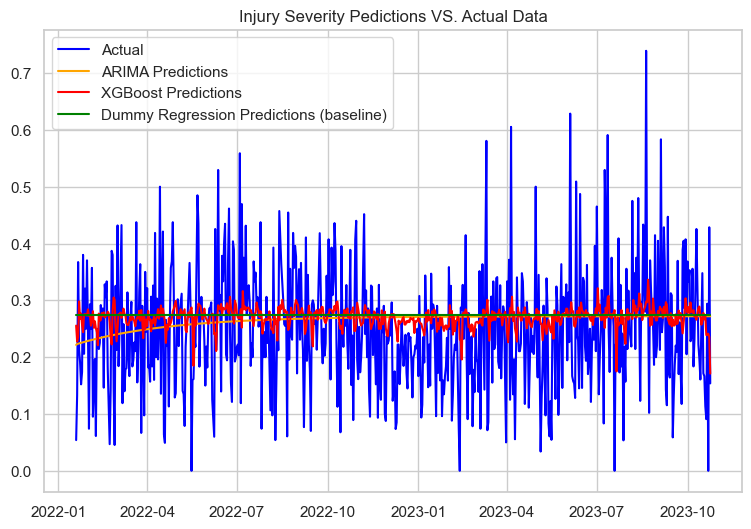

In [37]:
plt.figure(figsize=(9, 6))
plt.plot(ts_test.index, ts_test, label='Actual', color='blue')

plt.plot(ts_test.index, arima_predictions, label='ARIMA Predictions', color='orange')
plt.plot(ts_test.index, y_pred, label='XGBoost Predictions', color='red')
plt.plot(ts_test.index, dummy_predictions, label='Dummy Regression Predictions (baseline)', color='green')


plt.legend()
plt.title('Injury Severity Pedictions VS. Actual Data')
plt.show()